<a href="https://colab.research.google.com/github/michp15/DSC514_NLP_Project/blob/main/nlp_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Project (Chef)

In [1]:
%cd /content/drive/MyDrive/2nd semester msc/NLP/project

/content/drive/MyDrive/2nd semester msc/NLP/project


## Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
# for training
# import os
# os.environ['UNSLOTH_RETURN_LOGITS'] = '1'

## Unsloth

### Importing Qwen2.5-7B-bnb-4bit model

In [19]:
# bnb stands for bitsandbytes and the model is quantized at the 4bit level.

In [20]:
# all model training is done using the default and suggest parameters and settings of unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/Qwen2.5-7B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: We'll be using `/tmp/unsloth_compiled_cache` for temporary Unsloth patches.
Standard import failed for UnslothCPOTrainer: No module named 'UnslothCPOTrainer'. Using tempfile instead!
==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

### Get peft version of the model to do parameter efficient finetuning

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.4.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## Data Prep (Template and Transformation)

In [23]:
# the alpaca template is used in all of the models and the data preparation is the same in all. the columns instruction, normalized_ner and normalized_directions are formatted
# withing the alpaca prompt template, with normalized_ner and normalized_directions being renamed to input and output respectively. Then all are combined in a single field named text.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset

# load dataset in parts
train_ds = Dataset.from_parquet('train.parquet')
test_ds = Dataset.from_parquet('test.parquet')

train_ds_format = train_ds.map(formatting_prompts_func, batched = True,) # apply template
test_ds_format = test_ds.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9515 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Training - unsloth/Qwen2.5-7B-bnb-4bit

In [24]:
# The SFTTrainer module is then used to specify the training parameters which are retrieved directly from unsloth's recommendations.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds_format,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9515 [00:00<?, ? examples/s]

In [25]:
# we start the training process

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,515 | Num Epochs = 1 | Total steps = 1,189
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.857700
2,1.751400
3,1.673000
4,1.524900
5,1.513900
6,1.499900
7,1.437100
8,1.326200
9,1.147400
10,1.120600


## Inference

In [26]:
# Here, in the inference step we do some testing inference steps to jsut see if the model forms and gives back coherent answers. (and it is not stuck or repeating itself etc.)

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        "bread, ham, cheese", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nbread, ham, cheese\n\n### Response:\nspread bread with butter, layer ham and cheese, roll up and slice, bake at 350\\u00b0 degrees fahrenheitor 20 minutes.<|endoftext|>']

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        "pasta, minced meat, cheese", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\npasta, minced meat, cheese\n\n### Response:\ncook pasta according to package directions, drain and rinse, in a large bowl, combine pasta, meat, egg, salt, pepper and 1/2 degrees celsiusup cheese, mix well, spoon into a greased 13x9x2-inch baking dish, sprinkle with remaining cheese, bake at 350 degrees fahrenheitor 30 minutes or until heated through, serve with spaghetti sauce.<|endoftext|>']

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'eggs, flour, sugar, milk, butter, vanilla extract, baking powder, salt', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\neggs, flour, sugar, milk, butter, vanilla extract, baking powder, salt\n\n### Response:\nbeat eggs, add sugar, milk, butter and vanilla, sift flour, baking powder and salt, add to mixture, pour into greased and floured 9-inch tube pan, bake at 350\\u00b0 degrees fahrenheitor 1 hour.<|endoftext|>']

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'spaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nspaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil\n\n### Response:\ncook spaghetti in boiling salted water until al dente, drain and rinse with cold water, in a large bowl, beat eggs with a fork, add parmesan cheese, pancetta, pepper and salt, add spaghetti and toss to coat, serve immediately.<|endoftext|>']

## Save model

In [27]:
# save the model for later inference

In [ ]:
model.save_pretrained("./models/unsloth/Qwen2.5-7B-bnb-4bit")
tokenizer.save_pretrained("./models/unsloth/Qwen2.5-7B-bnb-4bit")

('./models/unsloth/Qwen2.5-7B-bnb-4bit/tokenizer_config.json',
 './models/unsloth/Qwen2.5-7B-bnb-4bit/special_tokens_map.json',
 './models/unsloth/Qwen2.5-7B-bnb-4bit/vocab.json',
 './models/unsloth/Qwen2.5-7B-bnb-4bit/merges.txt',
 './models/unsloth/Qwen2.5-7B-bnb-4bit/added_tokens.json',
 './models/unsloth/Qwen2.5-7B-bnb-4bit/tokenizer.json')

## Training - unsloth/mistral-7b-bnb-4bit

In [28]:
# here the process is the same as above

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/mistral-7b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset

# load dataset in parts
train_ds = Dataset.from_parquet('train.parquet')
test_ds = Dataset.from_parquet('test.parquet')

train_ds_format = train_ds.map(formatting_prompts_func, batched = True,) # apply template
test_ds_format = test_ds.map(formatting_prompts_func, batched = True,)

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds_format,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Unsloth 2025.4.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Map:   0%|          | 0/9515 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9515 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,515 | Num Epochs = 1 | Total steps = 1,189
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Step,Training Loss
1,1.952500
2,2.016600
3,1.718500
4,1.417200
5,1.292600
6,1.065200
7,1.072400
8,1.008500
9,0.848000
10,0.871800


In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'spaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nspaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil\n\n### Response:\ncook spaghetti according to package directions, drain and rinse with cold water, place spaghetti in a large bowl, add eggs, parmesan cheese, pancetta, pepper and salt, toss to combine, heat oil in a large skillet over medium heat, add spaghetti mixture and cook, stirring constantly, until spaghetti is golden brown, about 5 minutes, serve immediately.</s>']

In [ ]:
model.save_pretrained("./models/unsloth/mistral-7b-bnb-4bit/")
tokenizer.save_pretrained("./models/unsloth/mistral-7b-bnb-4bit/")

('./models/unsloth/mistral-7b-bnb-4bit/tokenizer_config.json',
 './models/unsloth/mistral-7b-bnb-4bit/special_tokens_map.json',
 './models/unsloth/mistral-7b-bnb-4bit/tokenizer.model',
 './models/unsloth/mistral-7b-bnb-4bit/added_tokens.json',
 './models/unsloth/mistral-7b-bnb-4bit/tokenizer.json')

## Training - TinyLlama

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/tinyllama-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset

# load dataset in parts
train_ds = Dataset.from_parquet('train.parquet')
test_ds = Dataset.from_parquet('test.parquet')

train_ds_format = train_ds.map(formatting_prompts_func, batched = True,) # apply template
test_ds_format = test_ds.map(formatting_prompts_func, batched = True,)

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds_format,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Unsloth 2025.4.7 patched 22 layers with 22 QKV layers, 22 O layers and 22 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9515 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,515 | Num Epochs = 1 | Total steps = 1,189
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 12,615,680/4,000,000,000 (0.32% trained)


Step,Training Loss
1,2.309200
2,2.404300
3,2.248800
4,2.169000
5,2.283600
6,2.509000
7,2.523400
8,2.567900
9,2.523600
10,2.203100


In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'ham, bread, cheese', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nham, bread, cheese\n\n### Response:\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread, cheese**\n\n**Ham, bread,']

In [ ]:
model.save_pretrained("./models/unsloth/tinyllama-bnb-4bit")
tokenizer.save_pretrained("./models/unsloth/tinyllama-bnb-4bit")

('./models/unsloth/tinyllama-bnb-4bit/tokenizer_config.json',
 './models/unsloth/tinyllama-bnb-4bit/special_tokens_map.json',
 './models/unsloth/tinyllama-bnb-4bit/tokenizer.model',
 './models/unsloth/tinyllama-bnb-4bit/added_tokens.json',
 './models/unsloth/tinyllama-bnb-4bit/tokenizer.json')

## Training - Gemma 2B

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/gemma-2b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset

# load dataset in parts
train_ds = Dataset.from_parquet('train.parquet')
test_ds = Dataset.from_parquet('test.parquet')

train_ds_format = train_ds.map(formatting_prompts_func, batched = True,) # apply template
test_ds_format = test_ds.map(formatting_prompts_func, batched = True,)

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds_format,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

==((====))==  Unsloth 2025.4.7: Fast Gemma patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.07G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Unsloth 2025.4.7 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


Map:   0%|          | 0/9515 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9515 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,515 | Num Epochs = 1 | Total steps = 1,189
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 19,611,648/2,000,000,000 (0.98% trained)


Step,Training Loss
1,2.606200
2,2.619600
3,2.441900
4,2.306500
5,2.304000
6,2.380800
7,2.215100
8,2.095400
9,1.829300
10,1.627500


In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'spaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['<bos>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nspaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil\n\n### Response:\ncook spaghetti according to package directions, drain and set aside, in a large bowl, beat eggs, add parmesan cheese, pancetta, pepper and salt, add spaghetti and toss to coat, pour into a 9 x 13-inch baking dish, bake at 350\\u00b0 degrees fahrenheitor 20 minutes, serve hot.<eos>']

In [ ]:
model.save_pretrained("./models/unsloth/gemma-2b-bnb-4bit")
tokenizer.save_pretrained("./models/unsloth/gemma-2b-bnb-4bit")

('./models/unsloth/gemma-2b-bnb-4bit/tokenizer_config.json',
 './models/unsloth/gemma-2b-bnb-4bit/special_tokens_map.json',
 './models/unsloth/gemma-2b-bnb-4bit/tokenizer.model',
 './models/unsloth/gemma-2b-bnb-4bit/added_tokens.json',
 './models/unsloth/gemma-2b-bnb-4bit/tokenizer.json')

## Training - unsloth/Qwen2.5-3B-unsloth-bnb-4bit

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/Qwen2.5-3B-unsloth-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import Dataset

# load dataset in parts
train_ds = Dataset.from_parquet('train.parquet')
test_ds = Dataset.from_parquet('test.parquet')

train_ds_format = train_ds.map(formatting_prompts_func, batched = True,) # apply template
test_ds_format = test_ds.map(formatting_prompts_func, batched = True,)

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds_format,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.4.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9515 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,515 | Num Epochs = 1 | Total steps = 1,189
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 29,933,568/3,000,000,000 (1.00% trained)


Step,Training Loss
1,2.206600
2,2.150200
3,2.004700
4,1.802100
5,1.763200
6,1.756000
7,1.760200
8,1.645400
9,1.488100
10,1.355200


In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        'You are an expert chef. Using the ingredients below, write a delicious food recipe.', # instruction
        'spaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil', # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are an expert chef. Using the ingredients below, write a delicious food recipe.\n\n### Input:\nspaghetti, eggs, parmesan cheese, pancetta, black pepper, salt, olive oil\n\n### Response:\ncook spaghetti according to package directions, drain and rinse with cold water, in a large bowl, combine spaghetti, eggs, parmesan cheese, pancetta, pepper and salt, mix well, heat olive oil in a large skillet over medium heat, add spaghetti mixture and cook, stirring occasionally, until heated through, about 5 minutes, serve immediately.<|endoftext|>']

In [ ]:
model.save_pretrained("./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit")
tokenizer.save_pretrained("./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit")

('./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/tokenizer_config.json',
 './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/special_tokens_map.json',
 './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/vocab.json',
 './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/merges.txt',
 './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/added_tokens.json',
 './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit/tokenizer.json')

## Evaluation

In [ ]:
!pip install -q evaluate bert-score rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00


In [29]:
import evaluate

# here we load several metrics from the evaluate module, such as bleu, rouge, and bertscore. The BLEU metric measures how similar a generated text is to a reference text by checking how many matching words and short phrases (n-grams) they share.
# The ROUGE metric measures how much of the reference text is captured in the generated text by comparing overlapping words, phrases, or sequences.
# The BERTScore metric checks how similar the meanings of the generated and reference texts are by using a BERT model to compare their word embeddings.

# Note: As you will see below there is rouge1, rouge2, and rougeL.
# ROUGE-1 measures how many individual words in the reference text also appear in the generated text.
# ROUGE-2 measures how many pairs of consecutive words (bigrams) in the reference text also appear in the generated text.
# ROUGE-L measures how much of the longest matching word sequence (not necessarily consecutive) from the reference appears in the generated text.

# Load metrics
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
bertscore = evaluate.load('bertscore')

def compute_all_metrics(predictions, references):
  # Clean and normalize
  predictions = [' '.join(p) if isinstance(p, list) else str(p).strip() for p in predictions]
  references = [' '.join(r) if isinstance(r, list) else str(r).strip() for r in references]

  # BLEU
  bleu_result = bleu.compute(
      predictions=predictions,
      references=references
  )

  # ROUGE
  rouge_result = rouge.compute(
      predictions=predictions,
      references=references,
      use_stemmer=True
  )

  # Helper to extract score (works for float or Score object)
  def get_f1(val):
      return float(val.mid.fmeasure) if hasattr(val, 'mid') else float(val)

  # BERTScore
  bertscore_result = bertscore.compute(
      predictions=predictions,
      references=references,
      lang='en'
  )

  return {
      'bleu': round(bleu_result['bleu'], 4),
      'rouge1': round(get_f1(rouge_result['rouge1']), 4),
      'rouge2': round(get_f1(rouge_result['rouge2']), 4),
      'rougeL': round(get_f1(rouge_result['rougeL']), 4),
      'bertscore_f1': round(sum(bertscore_result['f1']) / len(bertscore_result['f1']), 4)
  }

ModuleNotFoundError: No module named 'evaluate'

In [ ]:
# here the process is similar when we had to train the models. We just apply the prompt template for inference.

##from tqdm import tqdm
import torch
from unsloth import FastLanguageModel

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
"""

def generate_predictions(test_ds, model, tokenizer, max_new_tokens=128):
  predictions = []
  references = []

  FastLanguageModel.for_inference(model)

  for example in tqdm(test_ds):
      prompt = alpaca_prompt.format(
          example['instruction'],
          example['input'] if example['input'] else '',
          ''  # Leave response blank
      )

      inputs = tokenizer([prompt], return_tensors='pt').to('cuda')

      with torch.no_grad():
          outputs = model.generate(
              **inputs,
              max_new_tokens=max_new_tokens,
              use_cache=True,
          )

      decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
      gen_response = decoded[len(prompt):].strip() # get only the response section

      predictions.append(gen_response)
      references.append(example['output'].strip())

  return predictions, references

<ipython-input-6-7b3382fbef20>:3: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: We'll be using `/tmp/unsloth_compiled_cache` for temporary Unsloth patches.
Standard import failed for UnslothKTOTrainer: No module named 'UnslothKTOTrainer'. Using tempfile instead!


In [ ]:
pretrained = ["unsloth/Qwen2.5-7B-bnb-4bit", "unsloth/mistral-7b-bnb-4bit", "unsloth/tinyllama-bnb-4bit", "unsloth/gemma-2b-bnb-4bit", "unsloth/Qwen2.5-3B-unsloth-bnb-4bit"]
finetuned = ['./models/' + pret for pret in pretrained]
all_models = pretrained + finetuned
print(all_models)

['unsloth/Qwen2.5-7B-bnb-4bit', 'unsloth/mistral-7b-bnb-4bit', 'unsloth/tinyllama-bnb-4bit', 'unsloth/gemma-2b-bnb-4bit', 'unsloth/Qwen2.5-3B-unsloth-bnb-4bit', './models/unsloth/Qwen2.5-7B-bnb-4bit', './models/unsloth/mistral-7b-bnb-4bit', './models/unsloth/tinyllama-bnb-4bit', './models/unsloth/gemma-2b-bnb-4bit', './models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit']


In [ ]:
# We load the test dataset for inference.

import time
from datasets import Dataset
from unsloth import FastLanguageModel
import torch

test_ds = Dataset.from_parquet('test.parquet')

inference_times = []
scores = []

In [ ]:
# With a batch size of 1 we loop through the dataset and we perform inference, and we store the metrics for each model.
# We store inference time, and the previously discussed metrics.

for model_name in all_models:
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_name,
      max_seq_length = 2048,
      load_in_4bit = True,
  )
  start_time = time.time()
  predictions, references = generate_predictions(test_ds, model, tokenizer)
  end_time = time.time()
  inference_time = end_time - start_time
  inference_times.append(inference_time)
  print(f"Inference time for {model_name}: {inference_time} seconds")
  metrics = compute_all_metrics(predictions, references)
  scores.append(metrics)
  print(f"Metrics for {model_name}: {metrics}")

==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

100%|██████████| 500/500 [46:55<00:00,  5.63s/it]


Inference time for unsloth/mistral-7b-bnb-4bit: 2815.8933186531067 seconds
Metrics for unsloth/mistral-7b-bnb-4bit: {'bleu': 0.0215, 'rouge1': 0.2193, 'rouge2': 0.0387, 'rougeL': 0.1374, 'bertscore_f1': 0.7946}
==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

100%|██████████| 500/500 [31:50<00:00,  3.82s/it]


Inference time for unsloth/tinyllama-bnb-4bit: 1910.994707584381 seconds
Metrics for unsloth/tinyllama-bnb-4bit: {'bleu': 0.0093, 'rouge1': 0.1758, 'rouge2': 0.0276, 'rougeL': 0.1424, 'bertscore_f1': 0.7687}
==((====))==  Unsloth 2025.4.7: Fast Gemma patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.07G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

100%|██████████| 500/500 [24:45<00:00,  2.97s/it]


Inference time for unsloth/gemma-2b-bnb-4bit: 1485.6253213882446 seconds
Metrics for unsloth/gemma-2b-bnb-4bit: {'bleu': 0.0594, 'rouge1': 0.3126, 'rouge2': 0.0749, 'rougeL': 0.2106, 'bertscore_f1': 0.844}
==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

100%|██████████| 500/500 [56:20<00:00,  6.76s/it]


Inference time for unsloth/Qwen2.5-3B-unsloth-bnb-4bit: 3380.46023273468 seconds
Metrics for unsloth/Qwen2.5-3B-unsloth-bnb-4bit: {'bleu': 0.0141, 'rouge1': 0.2215, 'rouge2': 0.0324, 'rougeL': 0.1384, 'bertscore_f1': 0.79}
==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.
100%|██████████| 500/500 [34:12<00:00,  4.10s/it]


Inference time for ./models/unsloth/Qwen2.5-7B-bnb-4bit: 2052.409090280533 seconds
Metrics for ./models/unsloth/Qwen2.5-7B-bnb-4bit: {'bleu': 0.1363, 'rouge1': 0.4212, 'rouge2': 0.1737, 'rougeL': 0.3317, 'bertscore_f1': 0.8819}
==((====))==  Unsloth 2025.4.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
100%|██████████| 500/500 [40:12<00:00,  4.83s/it]


Inference time for ./models/unsloth/mistral-7b-bnb-4bit: 2412.7767617702484 seconds
Metrics for ./models/unsloth/mistral-7b-bnb-4bit: {'bleu': 0.1512, 'rouge1': 0.4481, 'rouge2': 0.1994, 'rougeL': 0.3598, 'bertscore_f1': 0.8865}
==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 22 layers with 22 QKV layers, 22 O layers and 22 MLP layers.
100%|██████████| 500/500 [46:47<00:00,  5.61s/it]


Inference time for ./models/unsloth/tinyllama-bnb-4bit: 2807.0979084968567 seconds
Metrics for ./models/unsloth/tinyllama-bnb-4bit: {'bleu': 0.0098, 'rouge1': 0.1797, 'rouge2': 0.0291, 'rougeL': 0.1465, 'bertscore_f1': 0.7694}
==((====))==  Unsloth 2025.4.7: Fast Gemma patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.
100%|██████████| 500/500 [21:58<00:00,  2.64s/it]


Inference time for ./models/unsloth/gemma-2b-bnb-4bit: 1318.679175376892 seconds
Metrics for ./models/unsloth/gemma-2b-bnb-4bit: {'bleu': 0.1248, 'rouge1': 0.4051, 'rouge2': 0.1637, 'rougeL': 0.3193, 'bertscore_f1': 0.8788}
==((====))==  Unsloth 2025.4.7: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.4.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.
100%|██████████| 500/500 [41:13<00:00,  4.95s/it]


Inference time for ./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit: 2473.457205057144 seconds
Metrics for ./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit: {'bleu': 0.1329, 'rouge1': 0.4125, 'rouge2': 0.1718, 'rougeL': 0.3232, 'bertscore_f1': 0.8801}


In [ ]:
# We export the models into a dataframe

import pandas as pd

# Combine metric dicts with inference time
rows = []
for model, metrics, time in zip(all_models, scores, inference_times):
    row = {'model': model, 'inference_time': time}
    row.update(metrics)
    rows.append(row)

df = pd.DataFrame(rows)

In [ ]:
print(df)
#df.to_csv('metrics.csv', index=False)

                                          model  inference_time    bleu  \
0                   unsloth/Qwen2.5-7B-bnb-4bit     2744.066392  0.0173   
1                   unsloth/mistral-7b-bnb-4bit     2815.893319  0.0215   
2                    unsloth/tinyllama-bnb-4bit     1910.994708  0.0093   
3                     unsloth/gemma-2b-bnb-4bit     1485.625321  0.0594   
4           unsloth/Qwen2.5-3B-unsloth-bnb-4bit     3380.460233  0.0141   
5          ./models/unsloth/Qwen2.5-7B-bnb-4bit     2052.409090  0.1363   
6          ./models/unsloth/mistral-7b-bnb-4bit     2412.776762  0.1512   
7           ./models/unsloth/tinyllama-bnb-4bit     2807.097908  0.0098   
8            ./models/unsloth/gemma-2b-bnb-4bit     1318.679175  0.1248   
9  ./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit     2473.457205  0.1329   

   rouge1  rouge2  rougeL  bertscore_f1  
0  0.2254  0.0357  0.1369        0.7923  
1  0.2193  0.0387  0.1374        0.7946  
2  0.1758  0.0276  0.1424        0.7687  
3  0.3

In [2]:
import pandas as pd

metrics = pd.read_csv('metrics.csv')

In [4]:
metrics

,model,inference_time,bleu,rouge1,rouge2,rougeL,bertscore_f1
0,unsloth/Qwen2.5-7B-bnb-4bit,2744.066392,0.0173,0.2254,0.0357,0.1369,0.7923
1,unsloth/mistral-7b-bnb-4bit,2815.893319,0.0215,0.2193,0.0387,0.1374,0.7946
2,unsloth/tinyllama-bnb-4bit,1910.994708,0.0093,0.1758,0.0276,0.1424,0.7687
3,unsloth/gemma-2b-bnb-4bit,1485.625321,0.0594,0.3126,0.0749,0.2106,0.8440
4,unsloth/Qwen2.5-3B-unsloth-bnb-4bit,3380.460233,0.0141,0.2215,0.0324,0.1384,0.7900
5,./models/unsloth/Qwen2.5-7B-bnb-4bit,2052.409090,0.1363,0.4212,0.1737,0.3317,0.8819
6,./models/unsloth/mistral-7b-bnb-4bit,2412.776762,0.1512,0.4481,0.1994,0.3598,0.8865
7,./models/unsloth/tinyllama-bnb-4bit,2807.097908,0.0098,0.1797,0.0291,0.1465,0.7694
8,./models/unsloth/gemma-2b-bnb-4bit,1318.679175,0.1248,0.4051,0.1637,0.3193,0.8788
9,./models/unsloth/Qwen2.5-3B-unsloth-bnb-4bit,2473.457205,0.1329,0.4125,0.1718,0.3232,0.8801


In [5]:
metrics['model'] = ['qwen-7b', 'mistral-7b', 'tinyllama', 'gemma-2b', 'qwen-3b', 'qwen-7b-finetuned', 'mistral-7b-finetuned', 'tinyllama-finetuned', 'gemma-2b-finetuned', 'qwen-3b-finetuned']

In [6]:
metrics

,model,inference_time,bleu,rouge1,rouge2,rougeL,bertscore_f1
0,qwen-7b,2744.066392,0.0173,0.2254,0.0357,0.1369,0.7923
1,mistral-7b,2815.893319,0.0215,0.2193,0.0387,0.1374,0.7946
2,tinyllama,1910.994708,0.0093,0.1758,0.0276,0.1424,0.7687
3,gemma-2b,1485.625321,0.0594,0.3126,0.0749,0.2106,0.8440
4,qwen-3b,3380.460233,0.0141,0.2215,0.0324,0.1384,0.7900
5,qwen-7b-finetuned,2052.409090,0.1363,0.4212,0.1737,0.3317,0.8819
6,mistral-7b-finetuned,2412.776762,0.1512,0.4481,0.1994,0.3598,0.8865
7,tinyllama-finetuned,2807.097908,0.0098,0.1797,0.0291,0.1465,0.7694
8,gemma-2b-finetuned,1318.679175,0.1248,0.4051,0.1637,0.3193,0.8788
9,qwen-3b-finetuned,2473.457205,0.1329,0.4125,0.1718,0.3232,0.8801


In [7]:
# local models outperform Hugging Face-hosted versions
# Gemma 2B stands out for speed/quality balance
# TinyLlama struggles in both accuracy and BLEU
# BLEU scores are low across the board

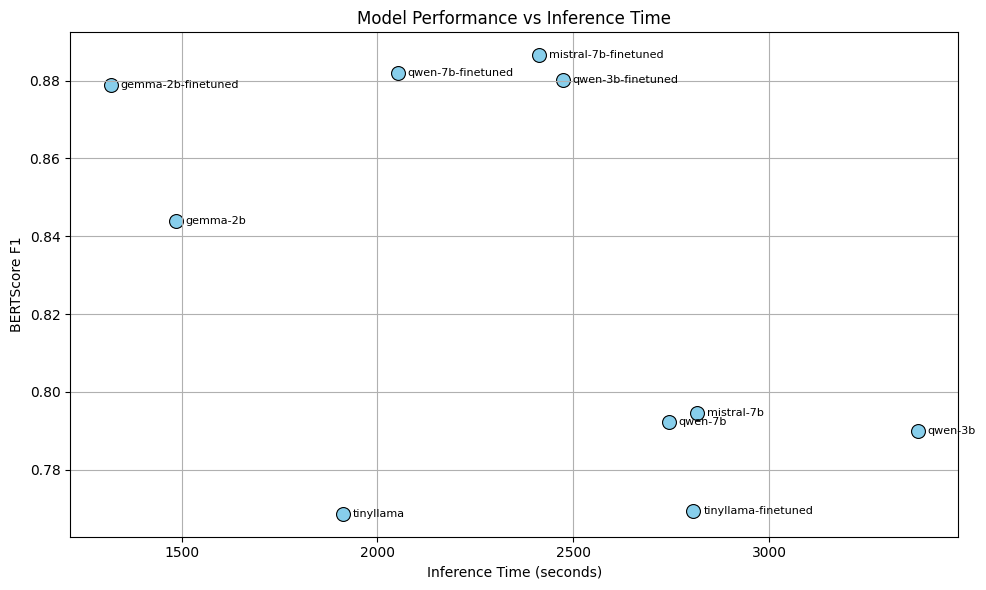

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by BERTScore for consistent label placement
metrics = metrics.sort_values(by='bertscore_f1', ascending=False)

# Create Seaborn scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=metrics,
    x='inference_time',
    y='bertscore_f1',
    s=100,
    color='skyblue',
    edgecolor='black'
)

# Add text labels for each point
for i, row in metrics.iterrows():
    plt.text(
        row['inference_time'] + 25,  # slight right offset
        row['bertscore_f1'],
        row['model'],
        fontsize=8,
        ha='left',
        va='center'
    )

# Add labels and styling
plt.xlabel('Inference Time (seconds)')
plt.ylabel('BERTScore F1')
plt.title('Model Performance vs Inference Time')
plt.grid(True)
plt.tight_layout()
plt.show()

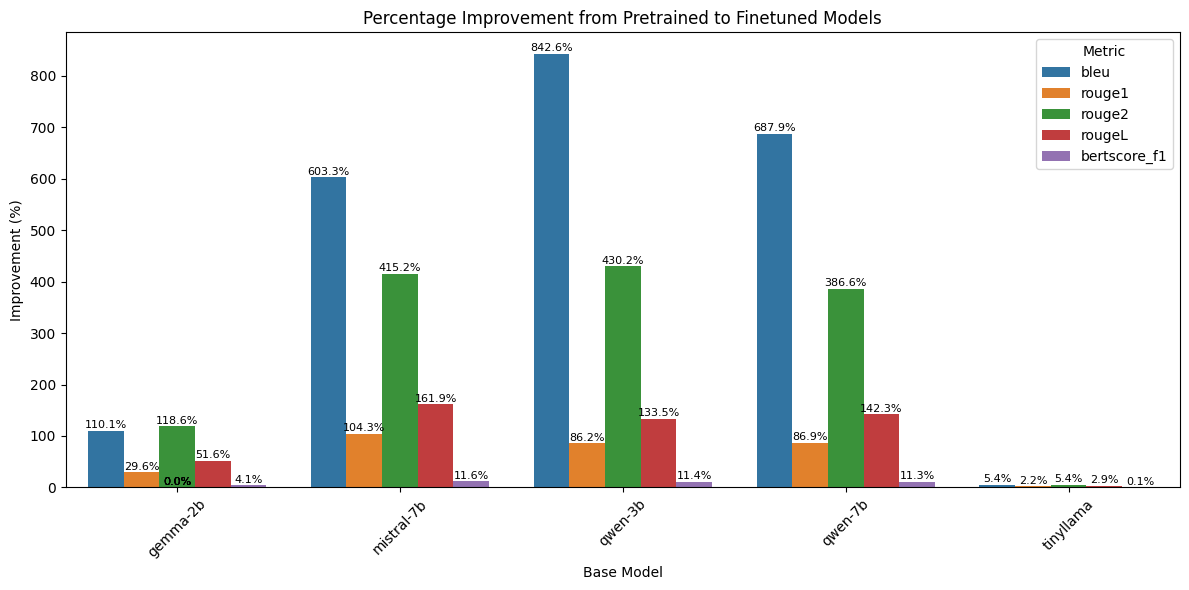

In [12]:
import seaborn as sns

# Define metrics and separate base vs. finetuned
eval_metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bertscore_f1']
base = metrics[~metrics['model'].str.contains('finetuned')].set_index('model')
finetuned = metrics[metrics['model'].str.contains('finetuned')].set_index('model')
finetuned.index = finetuned.index.str.replace('-finetuned', '', regex=False)

# Compute % improvement
percent_diff = ((finetuned[eval_metrics] - base[eval_metrics]) / base[eval_metrics]) * 100
percent_diff = percent_diff.reset_index().rename(columns={'model': 'base_model'})

# Reshape for seaborn
melted = percent_diff.melt(id_vars='base_model', var_name='metric', value_name='percent_improvement')

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=melted, x='base_model', y='percent_improvement', hue='metric')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Percentage Improvement from Pretrained to Finetuned Models')
plt.ylabel('Improvement (%)')
plt.xlabel('Base Model')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Add value labels
for bar in ax.patches:
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=0
        )

plt.tight_layout()
plt.show()

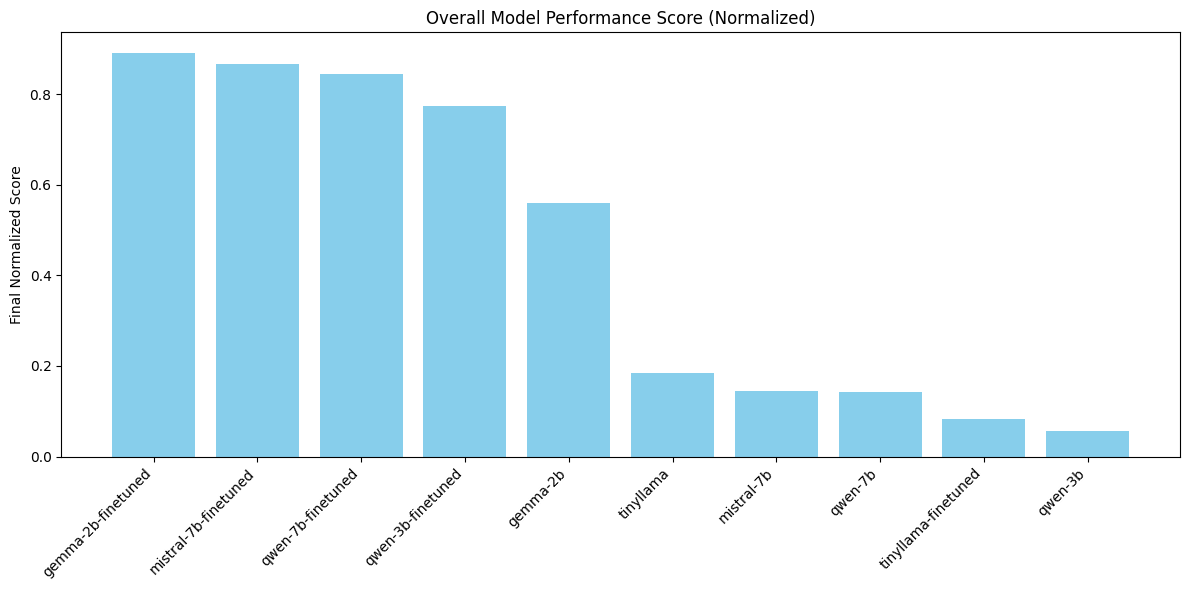

In [13]:
# Create a copy for scoring
scored = metrics.copy()

# Normalize metrics
for col in ['bleu', 'rougeL', 'bertscore_f1']:
    scored[f'{col}_norm'] = (scored[col] - scored[col].min()) / (scored[col].max() - scored[col].min())

# Invert inference time to get "speed"
scored['speed_norm'] = 1 - (scored['inference_time'] - scored['inference_time'].min()) / (scored['inference_time'].max() - scored['inference_time'].min())

# Compute final score (equal weights)
scored['final_score'] = scored[['bleu_norm', 'rougeL_norm', 'bertscore_f1_norm', 'speed_norm']].mean(axis=1)

# Sort by score
scored_sorted = scored.sort_values(by='final_score', ascending=False)

# Bar chart of final score
plt.figure(figsize=(12, 6))
plt.bar(scored_sorted['model'], scored_sorted['final_score'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Final Normalized Score')
plt.title('Overall Model Performance Score (Normalized)')
plt.tight_layout()
plt.show()

## Human Model Evaluation